In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
import torch
import torchinfo
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

#for data preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, classification_report,roc_auc_score, mean_squared_error, roc_curve,
                            auc, matthews_corrcoef,r2_score)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input
#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

import os
#print(os.listdir(r'C:\Users\AMJAD\AD\Datasets')

# Any results you write to the current directory are saved as output.

### Exploratory Data Analysis

In [2]:
df = pd.read_csv(r'C:\Users\AMJAD\AD\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\Datasets/creditcard_2023 - Copy.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


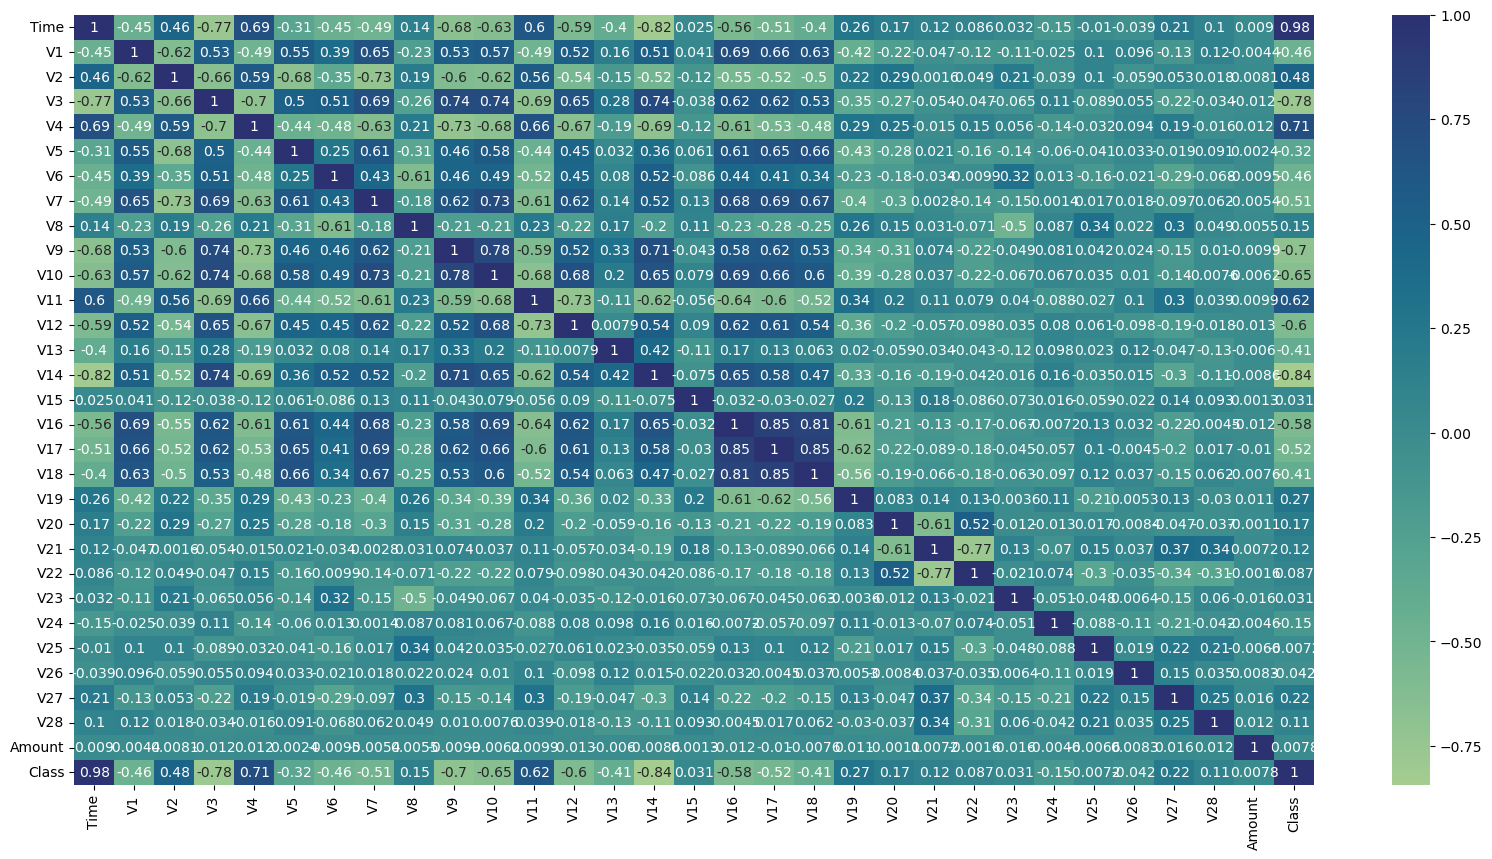

In [3]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(df.corr(),cmap='crest',annot=True)
plt.show()

<Axes: >

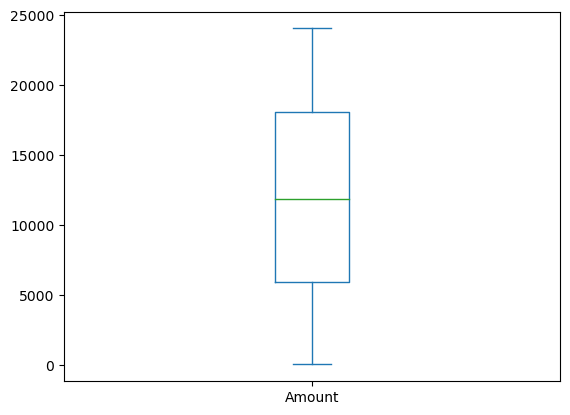

In [4]:
df['Amount'].plot.box()

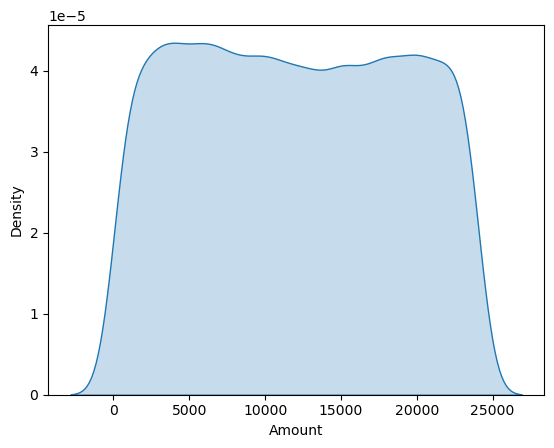

In [5]:
sns.kdeplot(data=df['Amount'], shade=True)
plt.show()

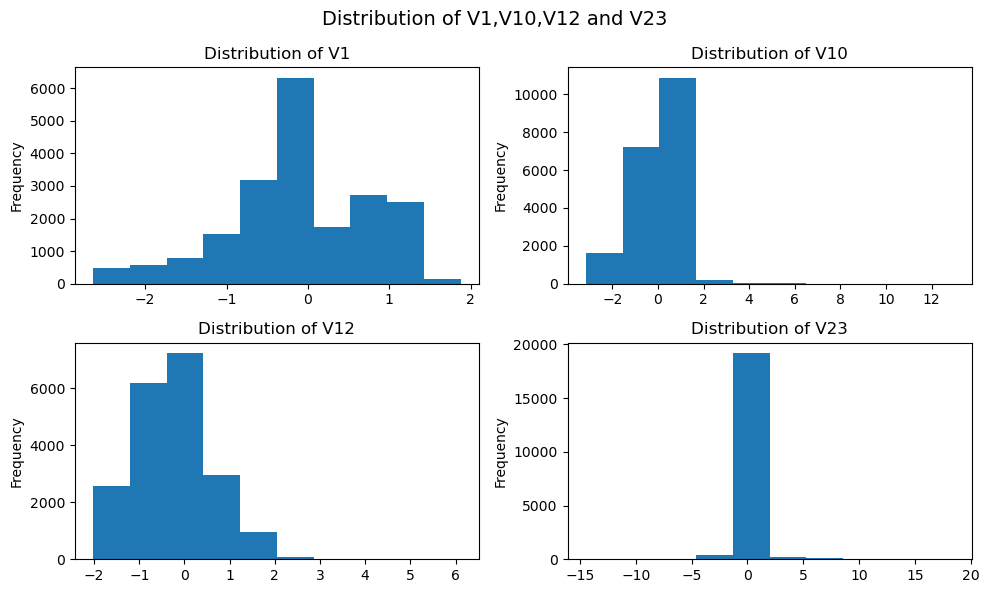

In [6]:
# Lets plot a histogram
paper, axes = plt.subplots(2, 2, figsize=(10, 6))
df['V1'].plot(kind='hist', ax=axes[0,0], title='Distribution of V1')
df['V10'].plot(kind='hist', ax=axes[0,1], title='Distribution of V10')
df['V12'].plot(kind='hist', ax=axes[1,0], title='Distribution of V12')
df['V23'].plot(kind='hist', ax=axes[1,1], title='Distribution of V23')
plt.suptitle('Distribution of V1,V10,V12 and V23',size=14)
plt.tight_layout()
plt.show()

Lets visualize how many fraud cases we have in this dataset

Only `Time` and `Amount` have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

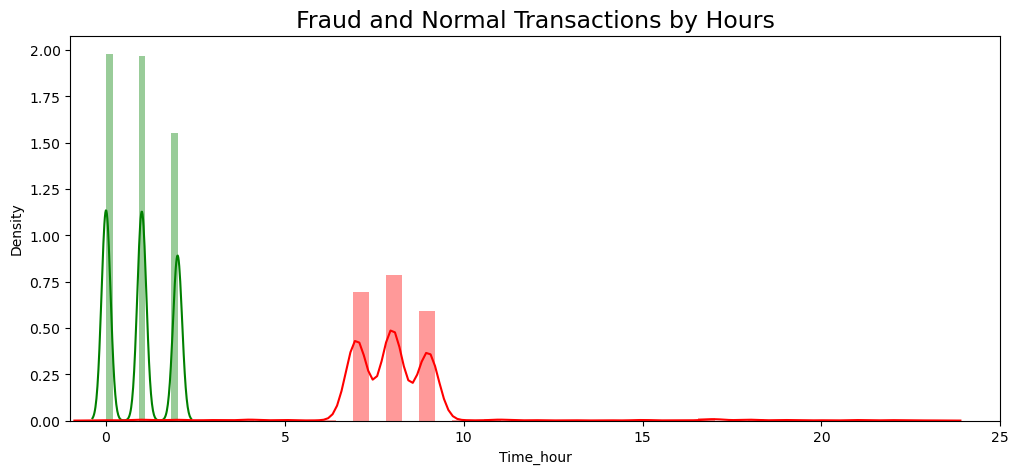

In [7]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Seems like hour of day have some impact on number or fraud cases. Lets move to transform the remaining features.

### Feature Transformation

Lets transform the remaining features using PCA.

In [8]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

#df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_hour', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

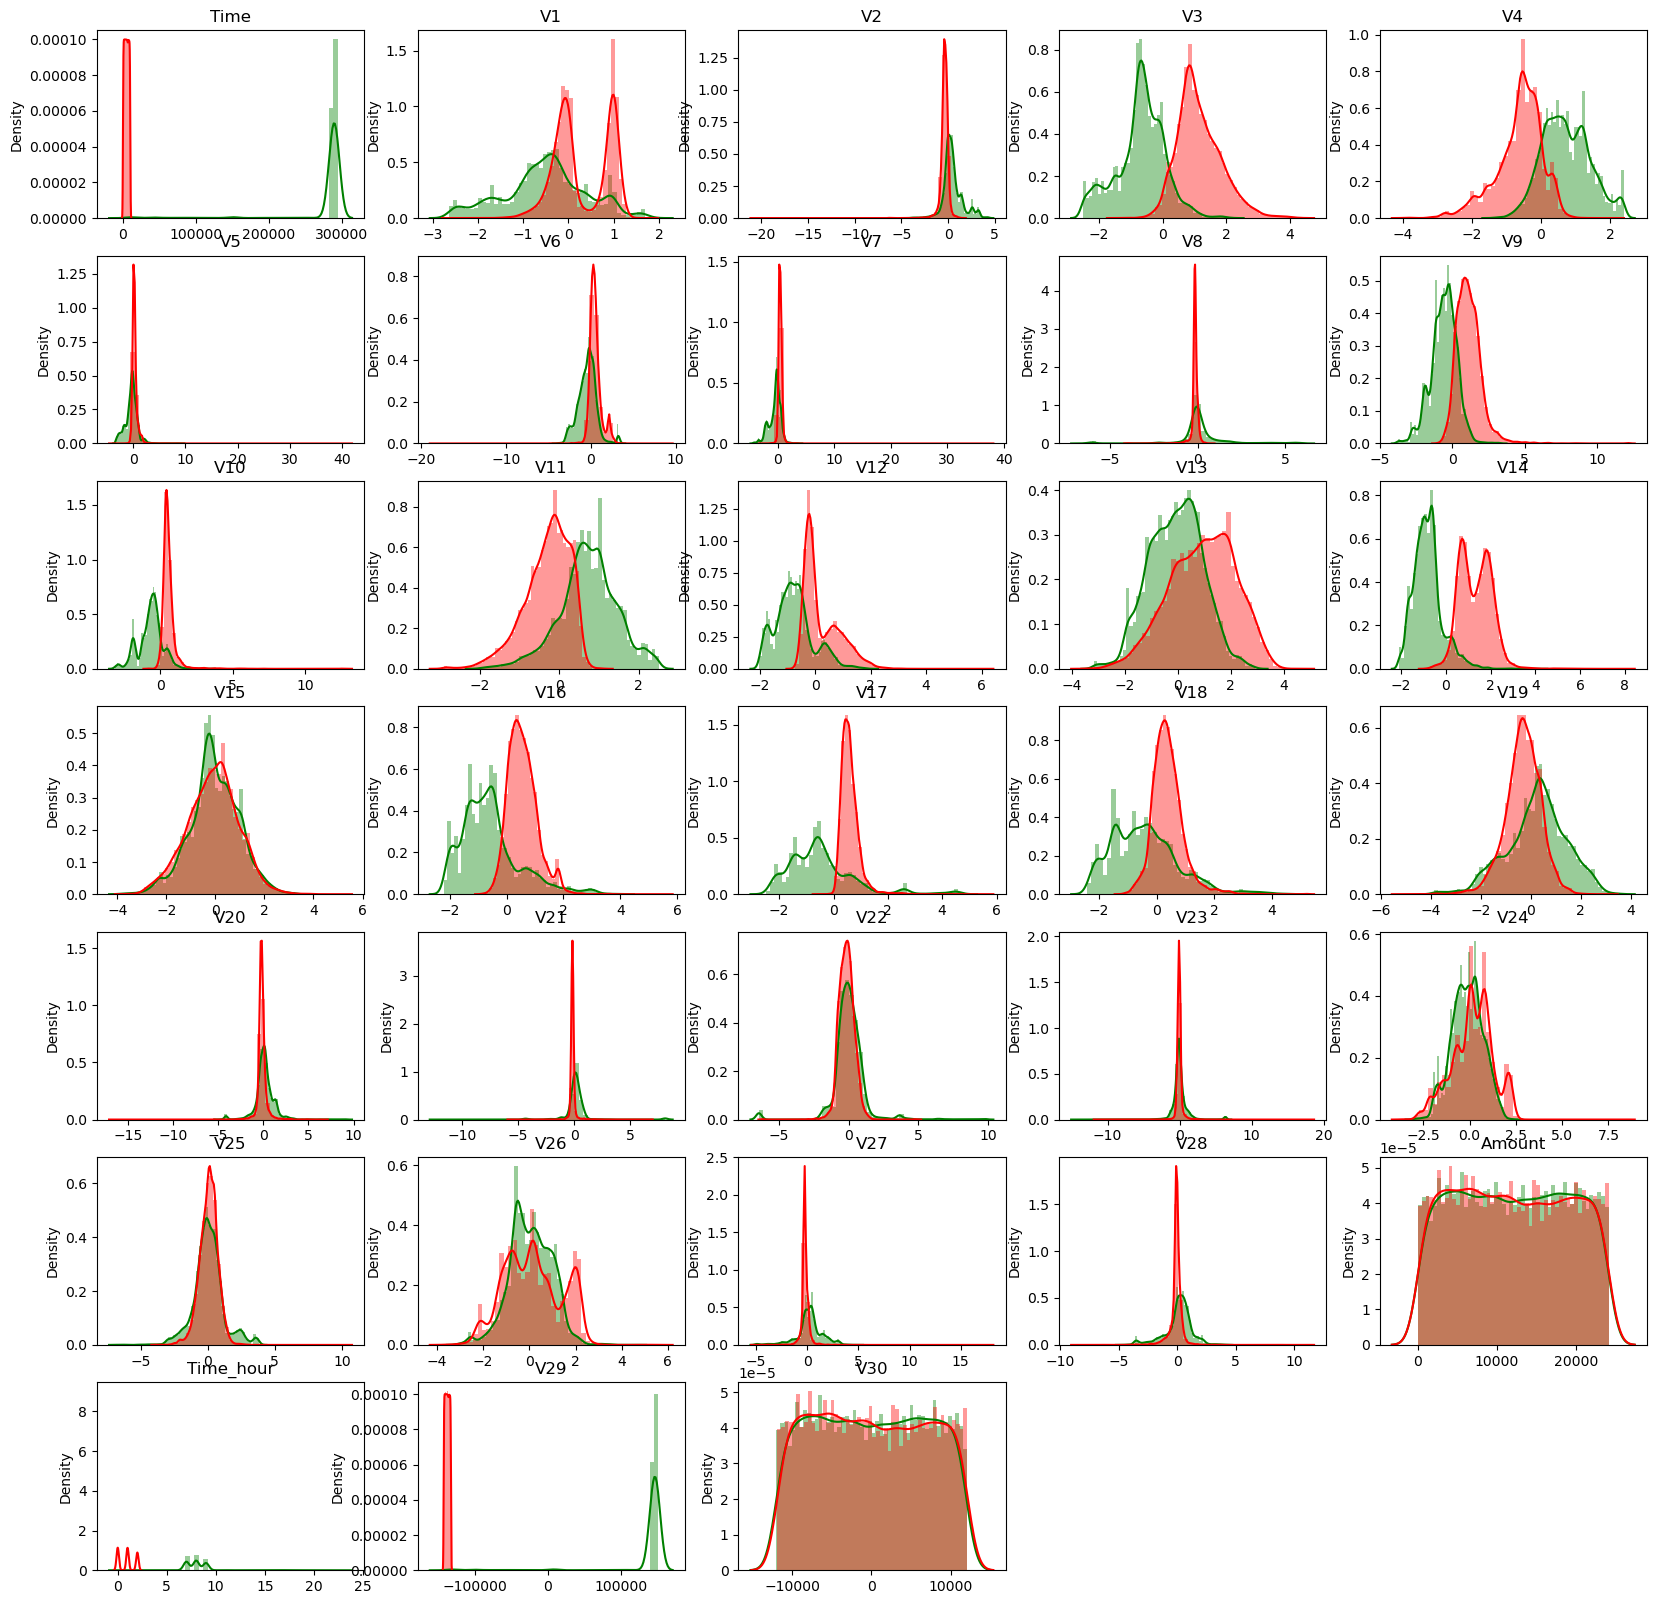

In [9]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(7, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

As we can see that data distribution of normal and fraud cases of some features like V18, V20, V25 are overlapping and they seem same. Such features are not good at differentiating between normal and fraud transactions. 

## Feature Selection using Statistical  Method


In [10]:
df.groupby('Class').corr()

Time        V1        V2        V3        V4        V5  \
Class                                                                         
0     Time       1.000000  0.071708 -0.011020  0.096319  0.126667 -0.018165   
      V1         0.071708  1.000000 -0.117535 -0.394315  0.133586 -0.198362   
      V2        -0.011020 -0.117535  1.000000  0.011949  0.014827 -0.359450   
      V3         0.096319 -0.394315  0.011949  1.000000  0.163928 -0.076104   
      V4         0.126667  0.133586  0.014827  0.163928  1.000000 -0.068931   
...                   ...       ...       ...       ...       ...       ...   
1     V28        0.007972  0.239054 -0.035982  0.169763 -0.215789  0.220990   
      Amount     0.010352 -0.000665  0.005103 -0.014769  0.018115  0.005935   
      Time_hour -0.166155 -0.001148 -0.015761  0.003775  0.005638  0.014169   
      V29        1.000000  0.029074 -0.025041  0.010458 -0.023812  0.026915   
      V30        0.007708 -0.000742  0.005169 -0.014797  0.018179  0.005864   

                       V6        V7        V8        V9  ...       V23  \
Class                                                    ...             
0     Time       0.000446 -0.094788 -0.012876  0.475501  ...  0.022997   
      V1         0.025181 -0.213985  0.139819 -0.055571  ... -0.090096   
      V2         0.135732  0.029172 -0.121258 -0.069024  ... -0.018948   
      V3        -0.103821  0.008497  0.004874  0.091041  ... -0.043381   
      V4        -0.001041 -0.017893  0.031783 -0.118199  ...  0.032470   
...                   ...       ...       ...       ...  ...       ...   
1     V28       -0.037879  0.170775  0.030627  0.247172  ...  0.057178   
      Amount    -0.014921 -0.006683  0.006248 -0.004553  ... -0.017353   
      Time_hour  0.002341 -0.004636 -0.019655 -0.014503  ...  0.000072   
      V29        0.021890  0.026215 -0.024034  0.012578  ...  0.008162   
      V30       -0.014979 -0.006752  0.006312 -0.004587  ... -0.017375   

                      V24       V25       V26       V27       V28    Amount  \
Class                                                                         
0     Time      -0.015943 -0.020144  0.262468 -0.070658 -0.001410 -0.010651   
      V1        -0.003794  0.366579  0.077720 -0.138868  0.052405 -0.001457   
      V2        -0.027761 -0.136203 -0.063534 -0.152744 -0.039338  0.005606   
      V3         0.014632 -0.257051  0.086068 -0.059655 -0.093776 -0.002344   
      V4        -0.075127 -0.043271  0.121851 -0.054676  0.016640  0.000920   
...                   ...       ...       ...       ...       ...       ...   
1     V28       -0.069504  0.260723  0.049692  0.234754  1.000000  0.019928   
      Amount    -0.009669 -0.010970  0.017205  0.020061  0.019928  1.000000   
      Time_hour  0.012293 -0.033178 -0.022906 -0.048437 -0.021592 -0.004399   
      V29       -0.009967 -0.016550 -0.006146 -0.023050  0.007973  0.010426   
      V30       -0.009643 -0.010927  0.017221  0.020122  0.019908  0.999997   

                 Time_hour       V29       V30  
Class                                           
0     Time        0.940371  0.999999 -0.010836  
      V1          0.103628  0.071707 -0.001470  
      V2         -0.025780 -0.011015  0.005608  
      V3          0.080057  0.096317 -0.002361  
      V4          0.129344  0.126669  0.000897  
...                    ...       ...       ...  
1     V28        -0.021592  0.007973  0.019908  
      Amount     -0.004399  0.010426  0.999997  
      Time_hour   1.000000 -0.166155 -0.003960  
      V29        -0.166155  1.000000  0.007782  
      V30        -0.003960  0.007782  1.000000  

[66 rows x 33 columns]

In [11]:
mean = df.groupby('Class').mean()

In [12]:
mean_df = mean.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\mean.csv')


In [13]:
mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 

In [14]:
mean

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,5010.9134,0.290956,-0.384941,1.160966,-0.618824,0.301939,0.517468,0.454414,-0.159643,1.138972,...,-0.047726,0.171049,0.073764,0.144347,-0.209281,-0.097711,11937.263335,0.9227,-138086.273742,7.327862
1,281183.4403,-0.509620,0.492563,-0.683038,0.734887,-0.346389,-0.430126,-0.497431,0.144702,-0.578538,...,0.012678,-0.119821,0.060207,0.053441,0.232982,0.101315,12044.891740,8.1078,138086.273742,-7.327862
Diff,-276172.5269,0.800576,-0.877504,1.844004,-1.353711,0.648328,0.947594,0.951845,-0.304345,1.717511,...,-0.060403,0.290869,0.013557,0.090906,-0.442263,-0.199026,-107.628405,-7.1851,-276172.547483,14.655724


In [15]:
# importing statistics module
import math
from statistics import variance
variance=df.groupby('Class').var()

In [16]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,8.400427e+06,0.36122,0.262367,0.487433,0.443724,0.436509,0.500942,0.258383,0.055617,0.786647,...,0.242090,1.219289,0.473230,1.503155,0.206505,0.409080,4.826757e+07,0.636388,8.400245e+06,4.826775e+07
1,1.704068e+09,0.81386,1.045099,0.576610,0.464393,1.345641,1.130744,1.052169,1.986346,0.774501,...,1.631283,0.692355,1.291051,0.823774,1.657691,1.362225,4.779115e+07,3.466926,1.704071e+09,4.778886e+07


In [17]:
variance_df =variance.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\variance.csv')


In [18]:
variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]

In [19]:
variance.loc['Diff1']=variance.iloc[2] / 28
#variance.loc['Diff1']=variance.iloc[3] / 10

In [20]:
variance.loc['Diff2']=np.sqrt(variance.iloc[3])
#variance.loc['Diff2']=np.sqrt(variance.iloc[4])

In [21]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,8.400427e+06,0.361220,0.262367,0.487433,0.443724,0.436509,0.500942,0.258383,0.055617,0.786647,...,0.242090,1.219289,0.473230,1.503155,0.206505,0.409080,4.826757e+07,0.636388,8.400245e+06,4.826775e+07
1,1.704068e+09,0.813860,1.045099,0.576610,0.464393,1.345641,1.130744,1.052169,1.986346,0.774501,...,1.631283,0.692355,1.291051,0.823774,1.657691,1.362225,4.779115e+07,3.466926,1.704071e+09,4.778886e+07
Diff,1.712469e+09,1.175080,1.307465,1.064043,0.908117,1.782150,1.631686,1.310551,2.041963,1.561148,...,1.873373,1.911644,1.764281,2.326929,1.864197,1.771305,9.605872e+07,4.103314,1.712471e+09,9.605661e+07
Diff1,6.115960e+07,0.041967,0.046695,0.038002,0.032433,0.063648,0.058274,0.046805,0.072927,0.055755,...,0.066906,0.068273,0.063010,0.083105,0.066578,0.063261,3.430669e+06,0.146547,6.115968e+07,3.430593e+06
Diff2,7.820460e+03,0.204859,0.216091,0.194940,0.180091,0.252286,0.241401,0.216346,0.270050,0.236126,...,0.258662,0.261291,0.251018,0.288279,0.258028,0.251517,1.852206e+03,0.382814,7.820465e+03,1.852186e+03


In [22]:
metric=mean.iloc[2]/variance.iloc[4]
#metric=mean.iloc[3]/variance.iloc[5]

In [23]:
abs(metric)

Time         35.314101
V1            3.907940
V2            4.060811
V3            9.459350
V4            7.516816
V5            2.569813
V6            3.925393
V7            4.399651
V8            1.126994
V9            7.273716
V10           6.404529
V11           5.885941
V12           5.553190
V13           3.364383
V14          11.742062
V15           0.232957
V16           5.319325
V17           4.560812
V18           3.375992
V19           2.129101
V20           1.317231
V21           0.918546
V22           0.651332
V23           0.233521
V24           1.113201
V25           0.054008
V26           0.315342
V27           1.714011
V28           0.791301
Amount        0.058108
Time_hour    18.769143
V29          35.314082
V30           0.007913
dtype: float64

In [24]:
abs(metric).sort_values( ascending=False)

Time         35.314101
V29          35.314082
Time_hour    18.769143
V14          11.742062
V3            9.459350
V4            7.516816
V9            7.273716
V10           6.404529
V11           5.885941
V12           5.553190
V16           5.319325
V17           4.560812
V7            4.399651
V2            4.060811
V6            3.925393
V1            3.907940
V18           3.375992
V13           3.364383
V5            2.569813
V19           2.129101
V27           1.714011
V20           1.317231
V8            1.126994
V24           1.113201
V21           0.918546
V28           0.791301
V22           0.651332
V26           0.315342
V23           0.233521
V15           0.232957
Amount        0.058108
V25           0.054008
V30           0.007913
dtype: float64

In [25]:
def smtest(feature):
    
    mean = df.groupby('Class').mean()
    mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 
    # importing statistics module
    import math
    from statistics import variance
    variance=df.groupby('Class').var()
    variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]
    variance.loc['Diff1']=variance.iloc[2] / 28
    variance.loc['Diff2']=np.sqrt(variance.iloc[3])
    metric=mean.iloc[2]/variance.iloc[4]
    abs(metric)
    fMetrix=abs(metric).sort_values( ascending=False)
    
    return fMetrix

In [26]:
#df.drop(['V21','V24','V27','V28','V30','V8','V26','V13','V15','V25','V23','V22',], axis=1, inplace=True)
df.drop(['V21','V28','V22','V26','V23','V15','Amount','V25','V30',], axis=1, inplace=True)

In [27]:
X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:



from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy=0.5, random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled, y_resampled = SMOTE(sampling_strategy='auto').fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [29]:

# Define a more complex DAGMM architecture
class ComplexDAGMM(nn.Module):
    def __init__(self, input_size, encoding_dim, num_gmm_components):
        super(ComplexDAGMM, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),  # Experiment with larger dimensions
            nn.Tanh(),
            nn.Linear(256, 128),  # Experiment with larger dimensions
            nn.Tanh(),
            nn.Linear(128, encoding_dim),  # Experiment with larger dimensions
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Reverse the order in the decoder
            nn.Tanh(),
            nn.Linear(128, 256),  # Reverse the order in the decoder
            nn.Tanh(),
            nn.Linear(256, input_size),  # Reverse the order in the decoder
        )
        self.estimation = nn.Sequential(
            nn.Linear(encoding_dim, num_gmm_components),
        )
        self.bn = nn.BatchNorm1d(encoding_dim, affine=False)

    def forward(self, x):
        x = self.encoder(x)
        z_c = self.bn(x)
        x_hat = self.decoder(x)
        gamma = self.estimation(z_c)
        return x_hat, z_c, gamma


In [30]:
# Hyperparameter tuning
best_params = None
best_score = 0

# Define your dataset and labels

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now you have X_train, X_val, X_test, y_train, y_val, y_test correctly defined



In [31]:
# Define the hyperparameter grid
param_grid = {
    'encoding_dim': [8, 16, 32],
    'learning_rate': [1e-5, 1e-6, 1e-7],
    'num_gmm_components': [3, 4, 5]
}

best_params = None
best_score = 0

for params in ParameterGrid(param_grid):
    # Train a DAGMM model with the current hyperparameters
    model = ComplexDAGMM(X_train.shape[1], params['encoding_dim'], params['num_gmm_components'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Training loop on the training set

    # Evaluation on the validation set
    x_hat_val, z_c_val, gamma_val = model(torch.Tensor(X_val))
    reconstruction_error_val = torch.sum((x_hat_val - torch.Tensor(X_val)) ** 2, dim=1).detach().numpy()
    
    # Calculate ROC AUC score or other chosen evaluation metric
    roc_auc = roc_auc_score(y_val, reconstruction_error_val)

    if roc_auc > best_score:
        best_score = roc_auc
        best_params = params

# Train the final model with the best hyperparameters on the combined training and validation sets
# Evaluate the final model on the test set
# Record and analyze the results

print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'encoding_dim': 32, 'learning_rate': 1e-05, 'num_gmm_components': 3}


In [32]:

# Train the model with the best hyperparameters
best_model = ComplexDAGMM(X_train.shape[1], best_params['encoding_dim'], best_params['num_gmm_components'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        best_optimizer.zero_grad()
        x_hat, z_c, gamma = best_model(torch.Tensor(batch))
        loss = criterion(x_hat, torch.Tensor(batch)) + 0.1 * torch.norm(gamma, p=2)
        loss.backward()
        best_optimizer.step()

# Evaluate the best model
x_hat, z_c, gamma = best_model(torch.Tensor(X_test))
reconstruction_error = torch.sum((x_hat - torch.Tensor(X_test)) ** 2, dim=1).detach().numpy()



In [33]:
# Print summary for the ComplexDAGMM model
model = ComplexDAGMM(X_train.shape[1], best_params['encoding_dim'], best_params['num_gmm_components'])
model.eval()
model_info = torchinfo.summary(model, (X_train.shape[0], X_train.shape[1]))
print(model_info)

# Print summary for the best_model
best_model.eval()
best_model_info = torchinfo.summary(best_model, (X_train.shape[0], X_train.shape[1]))
print(best_model_info)

Layer (type:depth-idx)                   Output Shape              Param #
ComplexDAGMM                             [12000, 24]               --
├─Sequential: 1-1                        [12000, 32]               --
│    └─Linear: 2-1                       [12000, 256]              6,400
│    └─Tanh: 2-2                         [12000, 256]              --
│    └─Linear: 2-3                       [12000, 128]              32,896
│    └─Tanh: 2-4                         [12000, 128]              --
│    └─Linear: 2-5                       [12000, 32]               4,128
│    └─Tanh: 2-6                         [12000, 32]               --
├─BatchNorm1d: 1-2                       [12000, 32]               --
├─Sequential: 1-3                        [12000, 24]               --
│    └─Linear: 2-7                       [12000, 128]              4,224
│    └─Tanh: 2-8                         [12000, 128]              --
│    └─Linear: 2-9                       [12000, 256]              33,02

In [34]:

# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)

# Classify anomalies
predictions = (reconstruction_error > threshold).astype(int)



In [35]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, predictions)
pr_auc = auc(fpr, tpr)
mcc = matthews_corrcoef(y_test, predictions)
r2 = r2_score(y_test, predictions)



In [36]:
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)
print("Matthews Correlation Coefficient:", mcc)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(predictions) / len(predictions))
print("False Positive Rate:", fpr[1])
classification = classification_report(y_test, predictions.astype(int))
print("Classification Report:")
print(classification)

Confusion Matrix:
 [[1968   94]
 [1832  106]]
Accuracy: 0.5185
Precision: 0.53
Recall: 0.054695562435500514
F1 Score: 0.0991580916744621
ROC AUC Score: 0.5045543767560625
PR AUC Score: 0.5045543767560625
Matthews Correlation Coefficient: 0.020886870335759648
R-squared (R2) Score: -0.9278526664124223
Anomaly Detection Rate: 0.05
False Positive Rate: 0.04558680892337536
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      2062
           1       0.53      0.05      0.10      1938

    accuracy                           0.52      4000
   macro avg       0.52      0.50      0.39      4000
weighted avg       0.52      0.52      0.39      4000



<Axes: >

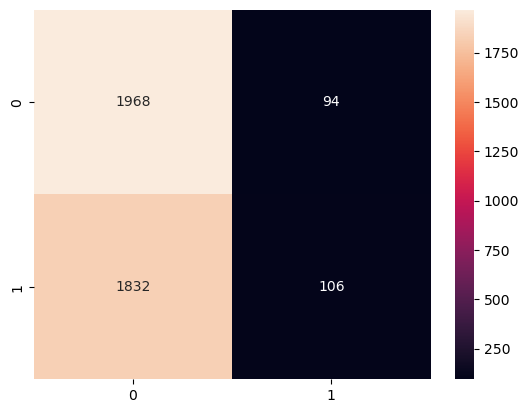

In [37]:

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')